Text classification with spacy	

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


In [23]:
#read data
df = pd.read_csv('data/research_paper.csv')
df.head()


,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS


In [24]:
df.isnull().sum()


Title         0
Conference    0
dtype: int64

In [25]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.33, random_state=42)
print('Research title sample:', train['Title'].iloc[0])
print('Conference of this paper:', train['Conference'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Research title sample: Cooperating with Smartness: Using Heterogeneous Smart Antennas in Ad-Hoc Networks.
Conference of this paper: INFOCOM
Training Data Shape: (1679, 2)
Testing Data Shape: (828, 2)


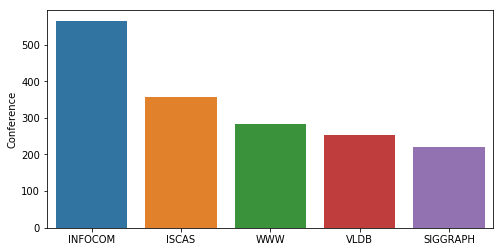

In [26]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train['Conference'].unique(), y=train['Conference'].value_counts())
plt.show()

In [27]:
import spacy
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [28]:
INFO_text = [text for text in train[train['Conference'] == 'INFOCOM']['Title']]
IS_text = [text for text in train[train['Conference'] == 'ISCAS']['Title']]
INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split() #get a list
IS_clean = cleanup_text(IS_text)
IS_clean = ' '.join(IS_clean).split()

Code just above is well written.

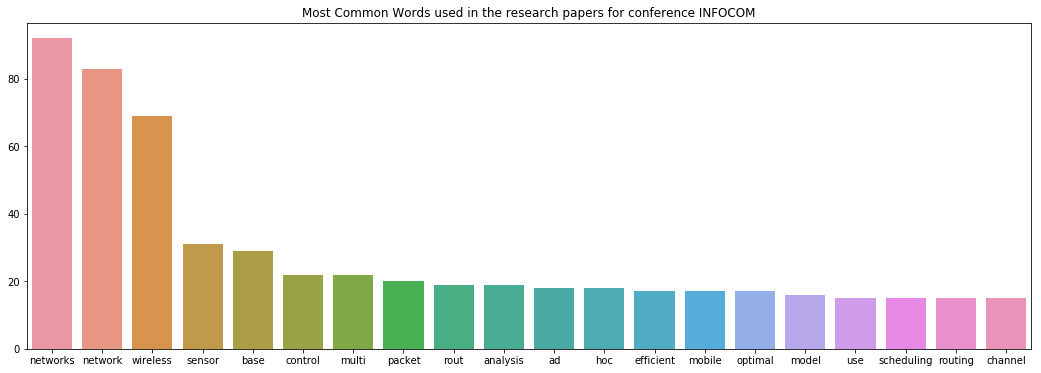

In [29]:
INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)
INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts)
plt.title('Most Common Words used in the research papers for conference INFOCOM')
plt.show()

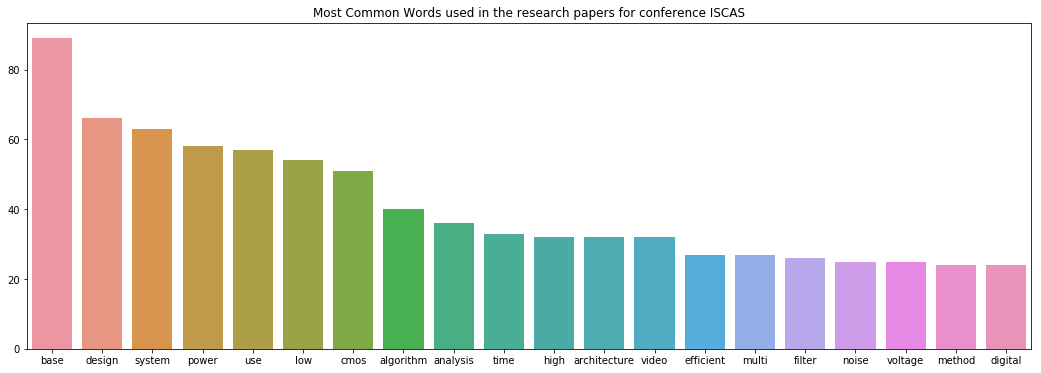

In [30]:
IS_common_words = [word[0] for word in IS_counts.most_common(20)]
IS_common_counts = [word[1] for word in IS_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=IS_common_words, y=IS_common_counts)
plt.title('Most Common Words used in the research papers for conference ISCAS')
plt.show()

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

In [41]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

class CleanTextTransformer(TransformerMixin):
    
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
   def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [45]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
        
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,2))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
# data
train1 = train['Title'].tolist()
labelsTrain1 = train['Conference'].tolist()
test1 = test['Title'].tolist()
labelsTest1 = test['Conference'].tolist()

In [46]:
print(train1[:5])

['Cooperating with Smartness: Using Heterogeneous Smart Antennas in Ad-Hoc Networks.', 'Maximizing throughput in wireless networks with finite internal buffers.', 'Experimental study of leakage-delay trade-off in Germanium pMOSFETs for logic circuits.', 'Fast dynamic reranking in large graphs.', 'An Efficient Algorithm for Mining Association Rules in Large Databases.']


In [47]:
# train
pipe.fit(train1, labelsTrain1)

Pipeline(memory=None,
     steps=[('cleanText', <__main__.CleanTextTransformer object at 0x11d66acc0>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [48]:
# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

accuracy: 0.7741545893719807
Top 10 features used to predict: 
Class 1 best: 
(-0.43533526417543833, 'database')
(-0.3539230332503614, 'web')
(-0.33987326118689076, 'social')
(-0.3330007099996817, 'analytics')
(-0.32152852199292176, 'analytics big')
(-0.32152852199292176, 'progressive')
(-0.32152852199292176, 'progressive analytics')
(-0.32152852199292176, 'scalable progressive')
(-0.31328103570822685, 'allocation resource')
(-0.31328103570822685, 'distribute information')
Class 2 best: 
(1.1480683688705695, 'speccast')
(0.7506909570465828, 'network')
(0.6507558862209363, 'route')
(0.5639553439898853, 'packet')
(0.5574079153762781, 'internet')
(0.5479488277592507, 'queue')
(0.5468703903319186, 'split')
(0.5371856990642832, 'multicast')
(0.5332590635280813, 'schedule')
(0.5281785228799116, 'manets')


This article is mostly motivated by sklearn.
Only text cleaning is made with spacy.